In [11]:
!pip install ucimlrepo
!pip install skorch


# !pip install --upgrade scikit-learn

import subprocess
# Installation on Google Colab
!git clone https://github.com/jlm429/pyperch
import sys


try:
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch', 'torch'])
except ImportError:
    pass

fatal: destination path 'pyperch' already exists and is not an empty directory.


In [57]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline, TSNEKL_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
# Modify your helpers module code outside of Jupyter Notebook or in another cell

# Reload the helpers module to get the latest changes
def reload_all():
  importlib.reload(helpers)
  importlib.reload(pipelines)
  importlib.reload(pipeline_helpers)


def generate_seed():
  np.random.seed(42)
  random.seed(42)
  torch.manual_seed(42)
  
import notebook_helper
from notebook_helper import reload_notebook_cell
  
generate_seed()



In [25]:
from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_raisin_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder


X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()
X_train_raisin, X_test_raisin, y_train_raisin, y_test_raisin = get_and_preprocess_raisin_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_raisin, y_test_encode_raisin, label_encoder_raisin = y_label_encode(y_train_raisin, y_test_raisin)


c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


## Picking the best perplexity on TSNE for SDAS and Raisin Datasets


Best parameters for SDAS: 5.0
Best parameters for Raisin: 50.0


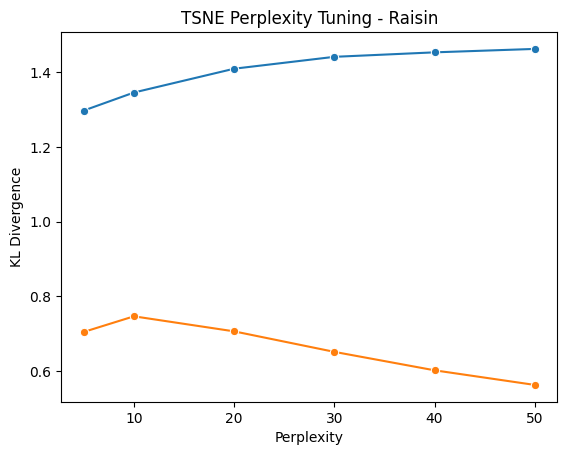

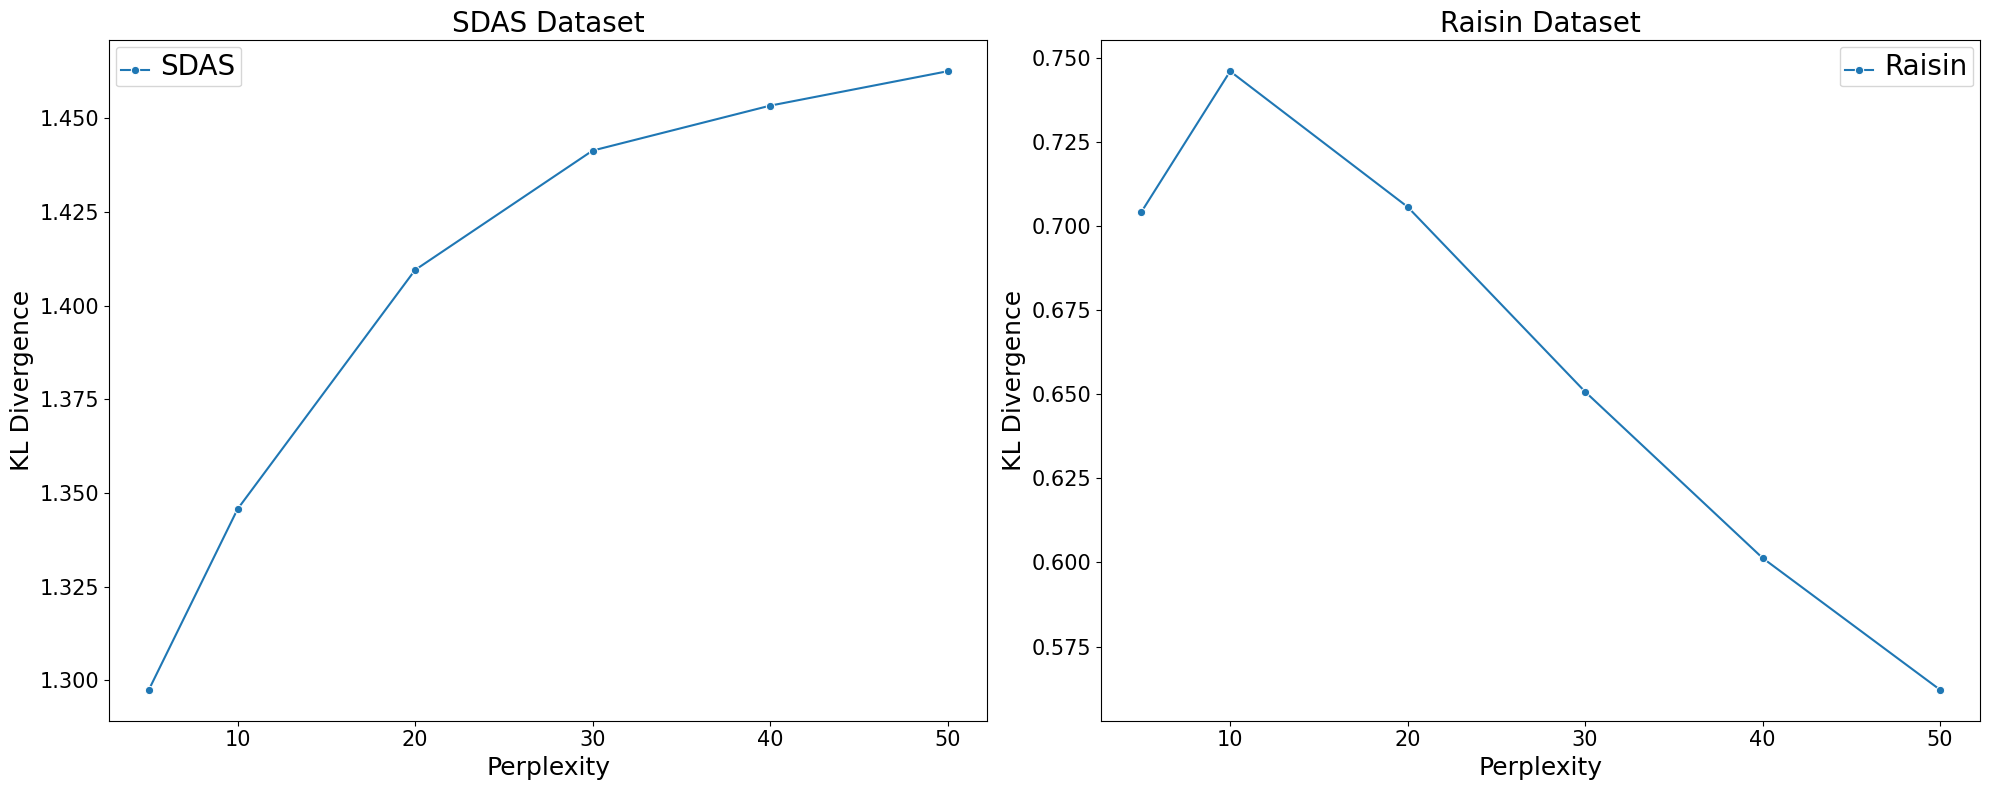

In [26]:
reload_all()
generate_seed()

# source https://www.datacamp.com/tutorial/introduction-t-sne get the minimum kl divergence for the perplexity
# Perform GridSearchCV for both datasets
best_params_sdas, results_sdas, best_tsne_model_sdas = pipeline_helpers.grid_search_tsne(X_train_sdas, CATEGORY_COLUMNS_UCML, "SDAS",sns)
best_params_raisin, results_raisin, best_tsne_model_raisin = pipeline_helpers.grid_search_tsne(X_train_raisin, [], "Raisin", sns)

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Best parameters for Raisin: {best_params_raisin}")

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=results_sdas, x='Perplexity', y='KL Divergence', label='SDAS' , marker='o', ax=axs[0]).set_title('SDAS Dataset')
sns.lineplot(data=results_raisin, x='Perplexity', y='KL Divergence', label='Raisin',  marker='o', ax=axs[1]).set_title('Raisin Dataset')

helpers.increase_font_size_subplots_included(plt)

plt.tight_layout()
plt.show()

## KMeans Analaysis 

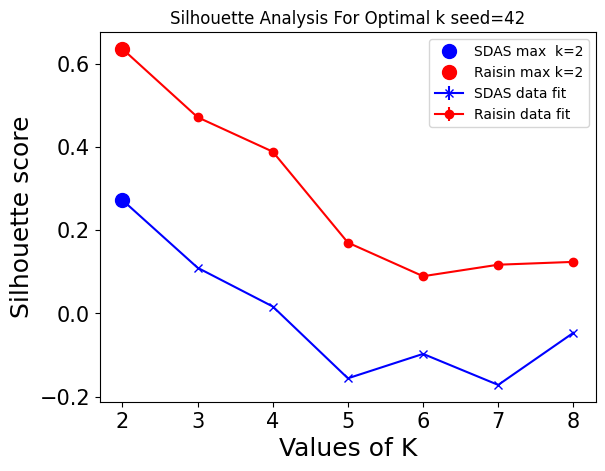

Max  silhouette score for SDAS data: 0.27221161231984853 at k=2
Max  silhouette score for Raisin data: 0.6354626224926063 at k=2


In [27]:
# create kmeans model from scikit-learn
generate_seed()
seeds = [42]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Initialize arrays to store silhouette scores for each seed
silhouette_scores_sdas = {k: [] for k in range_n_clusters}
silhouette_scores_raisin = {k: [] for k in range_n_clusters}

for seed in seeds:

    for num_clusters in range_n_clusters:
        # Initialise kmeans for SDAS
        kmean_kwargs = {'n_clusters': num_clusters, 'random_state': seed}
        kmeans_sdas =  KMeans_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kmean_kwargs)
        kmeans_sdas.fit(X_train_sdas)
        cluster_labels_sdas = kmeans_sdas['classifier'].labels_

        # Initialise kmeans for Raisin
        kmeans_raisin = KMeans_pipeline(X_train_raisin, **kmean_kwargs)
        kmeans_raisin.fit(X_train_raisin)
        cluster_labels_raisin = kmeans_raisin['classifier'].labels_

        # Silhouette score
        silhouette_scores_sdas[num_clusters].append(silhouette_score(X_train_sdas, cluster_labels_sdas))
        silhouette_scores_raisin[num_clusters].append(silhouette_score(X_train_raisin, cluster_labels_raisin))

# Calculate mean and standard deviation of silhouette scores across seeds
mean_silhouette_sdas = [np.mean(silhouette_scores_sdas[k]) for k in range_n_clusters]
std_silhouette_sdas = [np.std(silhouette_scores_sdas[k]) for k in range_n_clusters]

mean_silhouette_raisin = [np.mean(silhouette_scores_raisin[k]) for k in range_n_clusters]
std_silhouette_raisin = [np.std(silhouette_scores_raisin[k]) for k in range_n_clusters]

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis For Optimal k seed=42")
plt.legend()
plt.show()

print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

# source https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/


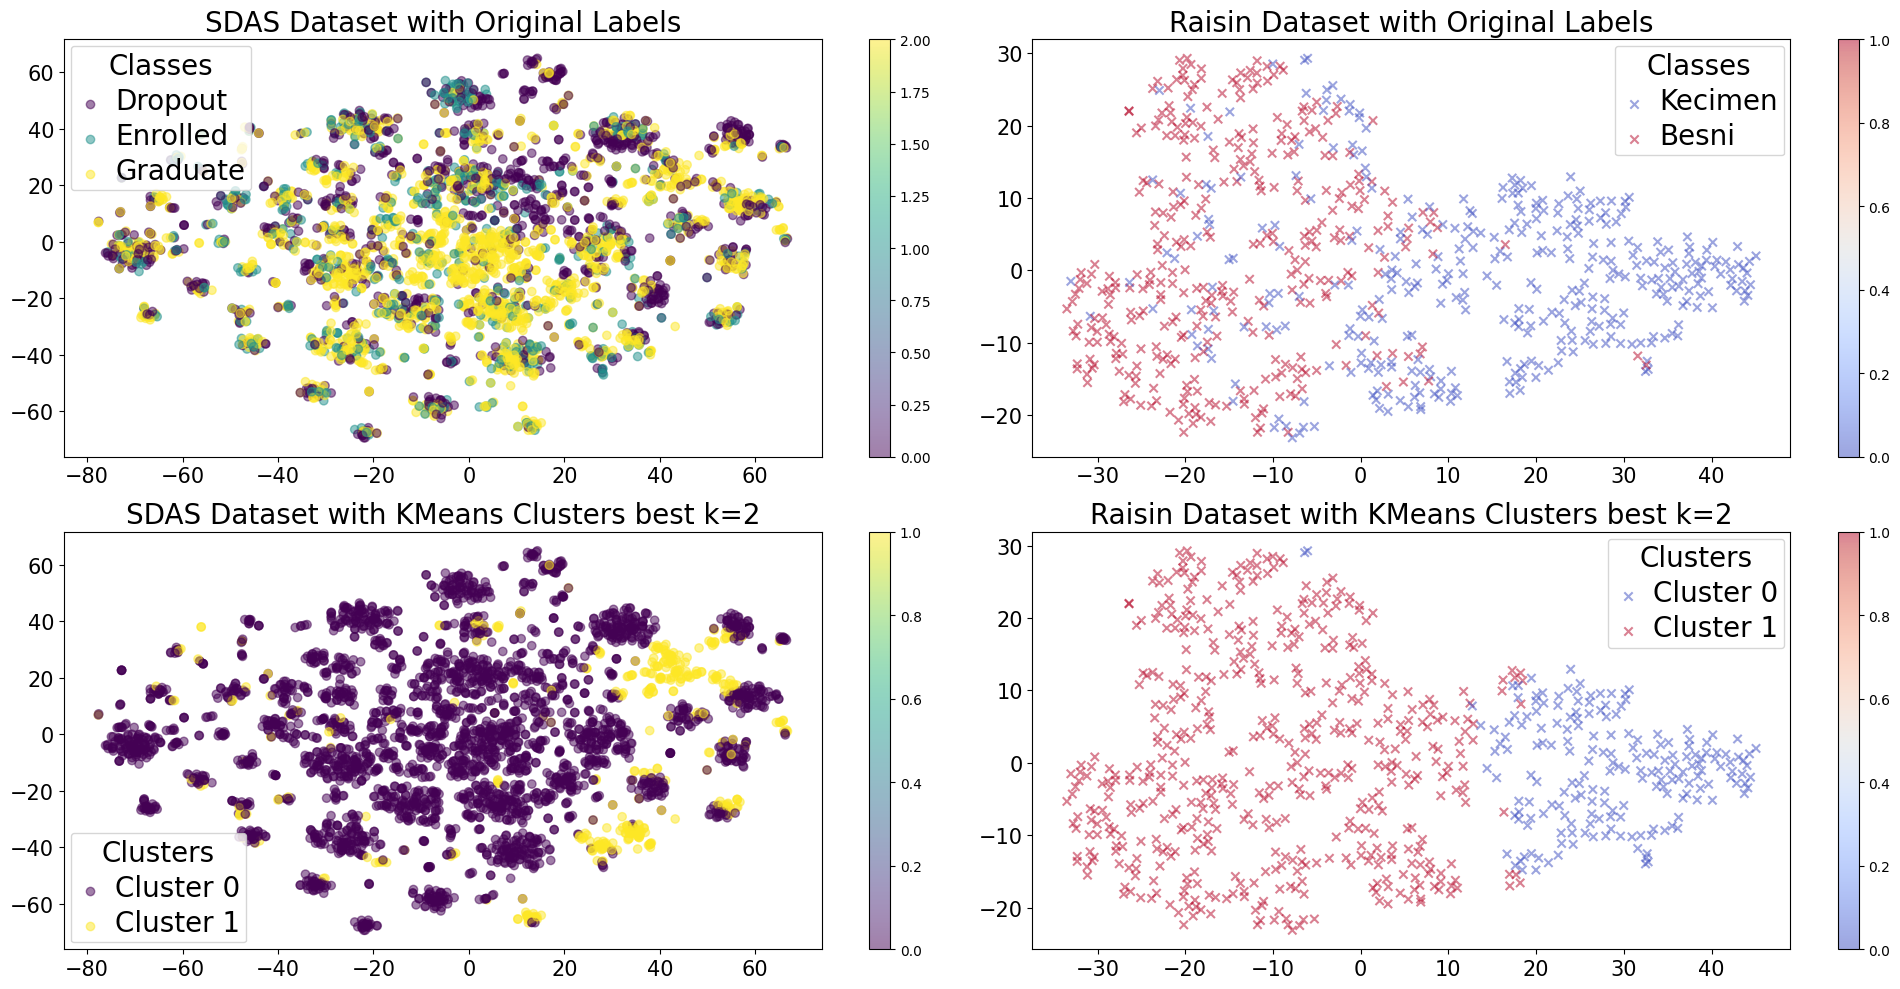

In [29]:
# Visualize clusters vs original labels using t-SNE
if 'best_tsne_model_sdas' in locals().keys() and 'best_tsne_model_raisin' in locals().keys():
    tsne_raisin = best_tsne_model_raisin
    tsne_sdas = best_tsne_model_sdas
else:
    kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
    kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
    tsne_sdas = TSNE_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
    tsne_raisin = TSNE_pipeline(X_train_raisin, **kwargs_raisin_tsne)
kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 30}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42}
tsne_sdas = TSNE_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(X_train_raisin, **kwargs_raisin_tsne)

X_train_sdas_tsne = tsne_sdas.fit_transform(X_train_sdas)
X_train_raisin_tsne = tsne_raisin.fit_transform(X_train_raisin)

# Display confusion matrix for the best K
best_k_sdas = max_mean_sdas_k
best_k_raisin = max_mean_raisin_k

# Fit KMeans with best K
kmean_kwargs_sdas = {'n_clusters': best_k_sdas, 'random_state': 42}
kmeans_sdas_best = KMeans_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kmean_kwargs_sdas)
kmeans_sdas_best.fit(X_train_sdas)
cluster_labels_sdas_best = kmeans_sdas_best['classifier'].labels_

kmeans_kwargs_raisin = {'n_clusters': best_k_raisin, 'random_state': 42}
kmeans_raisin_best = KMeans_pipeline(X_train_raisin, **kmeans_kwargs_raisin)
kmeans_raisin_best.fit(X_train_raisin)
cluster_labels_raisin_best = kmeans_raisin_best['classifier'].labels_

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

# Create 2 pairs of subplots
plt.figure(figsize=(20, 10))

# First pair of subplots: Original labels
plt.subplot(2, 2, 1)
plt.title("SDAS Dataset with Original Labels")
scatter_sdas = plt.scatter(X_train_sdas_tsne[:, 0], X_train_sdas_tsne[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [label_mapping_sdas[int(i)] for i in np.unique(y_train_encoded_sdas)]

plt.legend(handles_sdas, labels_sdas, title="Classes")
helpers.increase_font_size(plt)
plt.subplot(2, 2, 2)
plt.title("Raisin Dataset with Original Labels")
scatter_raisin = plt.scatter(X_train_raisin_tsne[:, 0], X_train_raisin_tsne[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [label_mapping_raisin[int(i)] for i in np.unique(y_train_encode_raisin)]

plt.legend(handles_raisin, labels_raisin, title="Classes")
helpers.increase_font_size(plt)
# Second pair of subplots: KMeans clusters
plt.subplot(2, 2, 3)
plt.title(f"SDAS Dataset with KMeans Clusters best k={best_k_sdas}")
scatter_sdas_kmeans = plt.scatter(X_train_sdas_tsne[:, 0], X_train_sdas_tsne[:, 1], c=cluster_labels_sdas_best, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS KMeans clusters
handles_sdas_kmeans, _ = scatter_sdas_kmeans.legend_elements()
labels_sdas_kmeans = [f"Cluster {int(i)}" for i in np.unique(cluster_labels_sdas_best)]

plt.legend(handles_sdas_kmeans, labels_sdas_kmeans, title="Clusters")
helpers.increase_font_size(plt)
plt.subplot(2, 2, 4)
plt.title(f"Raisin Dataset with KMeans Clusters best k={best_k_raisin}")
scatter_raisin_kmeans = plt.scatter(X_train_raisin_tsne[:, 0], X_train_raisin_tsne[:, 1], c=cluster_labels_raisin_best, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin KMeans clusters
handles_raisin_kmeans, _ = scatter_raisin_kmeans.legend_elements()
labels_raisin_kmeans = [f"Cluster {int(i)}" for i in np.unique(cluster_labels_raisin_best)]

plt.legend(handles_raisin_kmeans, labels_raisin_kmeans, title="Clusters")
helpers.increase_font_size(plt)
plt.tight_layout()

plt.show()



In [66]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], cluster_labels_sdas_best, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": cluster_labels_sdas_best})

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")



# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": cluster_labels_sdas_best})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")

# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.182136  0.891135
2  Graduate   0.577608  0.126745


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


True Labels,Dropout,Enrolled,Graduate
Cluster Labels,,,
0,1009,573,1564
1,96,70,227


In [67]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], cluster_labels_raisin_best, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": cluster_labels_raisin_best})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x else "Kecimen")



# Map cluster labels to the original labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": cluster_labels_raisin_best})
cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x else "Kecimen")

# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.331439  0.480769
1  Kecimen   0.015625  0.008427


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels,Besni,Kecimen
Cluster Labels,,
0,189,3
1,175,353


## Expectation Maximization

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
reload_all()

,Class
10,Kecimen
334,Kecimen
244,Kecimen
678,Besni
306,Kecimen
...,...
106,Kecimen
270,Kecimen
860,Besni
435,Kecimen


C:\Users\WarrenKushner\AppData\Local\Temp\ipykernel_30472\1153809900.py:50: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')  # Set y-axis to log scale


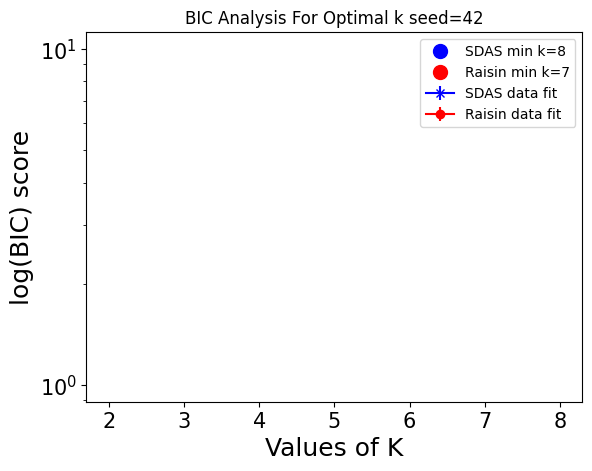

Min BIC score for SDAS data: -2283896.7854789887 at k=8
Min BIC score for Raisin data: -4646.327070114058 at k=7


In [64]:
reload_all()


seeds = [42]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Initialize arrays to store BIC scores for each seed
bic_scores_sdas = {k: [] for k in range_n_clusters}
bic_scores_raisin = {k: [] for k in range_n_clusters}

for seed in seeds:
    for num_clusters in range_n_clusters:
        # Initialize GMM for SDAS
        gmm_kwargs = {'n_components': num_clusters, 'random_state': seed}
        gmm_sdas = pipelines.GMM_pipeline(X_train_sdas, [], **gmm_kwargs)
        gmm_sdas.fit(X_train_sdas)
        X_train_sdas_scaled = pipelines.preprocess_pipeline(X_train_sdas, CATEGORY_COLUMNS_UCML).fit_transform(X_train_sdas)
        bic_scores_sdas[num_clusters].append(gmm_sdas['classifier'].bic(X_train_sdas_scaled))

        # Initialize GMM for Raisin
        gmm_raisin = pipelines.GMM_pipeline(X_train_raisin, **gmm_kwargs)
        gmm_raisin.fit(X_train_raisin)
        X_train_raisin_scaled = pipelines.preprocess_pipeline(X_train_raisin,[]).fit_transform(X_train_raisin)  
        bic_scores_raisin[num_clusters].append(gmm_raisin['classifier'].bic(X_train_raisin_scaled))

# Calculate mean and standard deviation of BIC scores across seeds
mean_bic_sdas = [np.mean(bic_scores_sdas[k]) for k in range_n_clusters]
std_bic_sdas = [np.std(bic_scores_sdas[k]) for k in range_n_clusters]

mean_bic_raisin = [np.mean(bic_scores_raisin[k]) for k in range_n_clusters]
std_bic_raisin = [np.std(bic_scores_raisin[k]) for k in range_n_clusters]

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_bic_sdas, yerr=std_bic_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_bic_raisin, yerr=std_bic_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the minimum mean BIC score points
min_mean_sdas_bic = min(mean_bic_sdas)
min_mean_sdas_k = range_n_clusters[mean_bic_sdas.index(min_mean_sdas_bic)]
plt.plot(min_mean_sdas_k, min_mean_sdas_bic, "bo", markersize=10, label=f'SDAS min k={min_mean_sdas_k}')

min_mean_raisin_bic = min(mean_bic_raisin)
min_mean_raisin_k = range_n_clusters[mean_bic_raisin.index(min_mean_raisin_bic)]
plt.plot(min_mean_raisin_k, min_mean_raisin_bic, "ro", markersize=10, label=f'Raisin min k={min_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("log(BIC) score")
plt.title("BIC Analysis For Optimal k seed=42")
plt.legend()
plt.yscale('log')  # Set y-axis to log scale

plt.show()

print(f"Min BIC score for SDAS data: {min_mean_sdas_bic} at k={min_mean_sdas_k}")
print(f"Min BIC score for Raisin data: {min_mean_raisin_bic} at k={min_mean_raisin_k}")# 
# getting optimum number of clusters

Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
Min BIC score for SDAS: 306992.66473296314
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
Min BIC score for Raisin: 54.834866983853


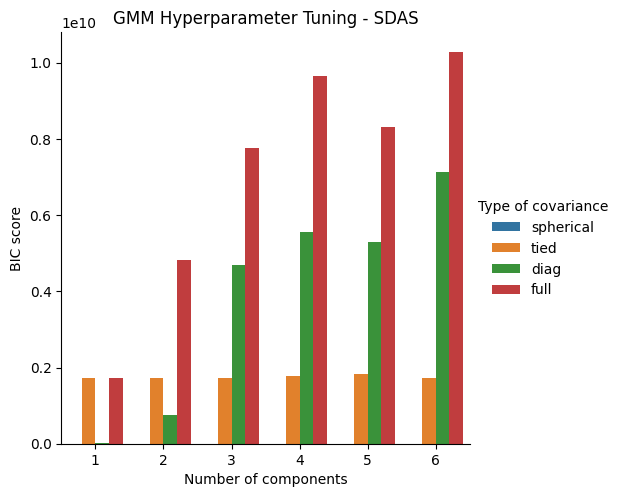

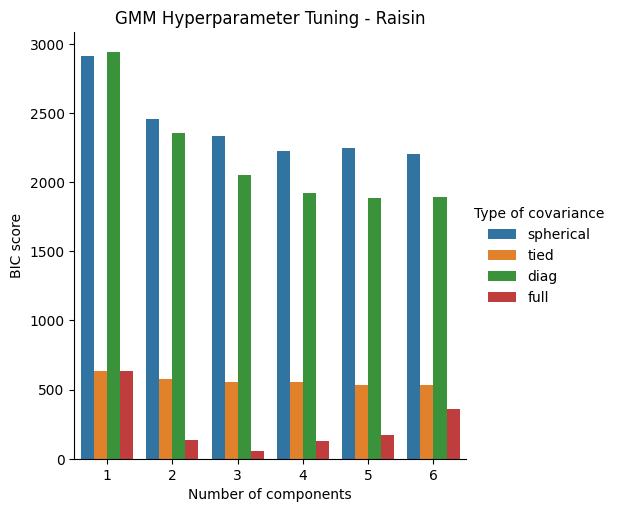

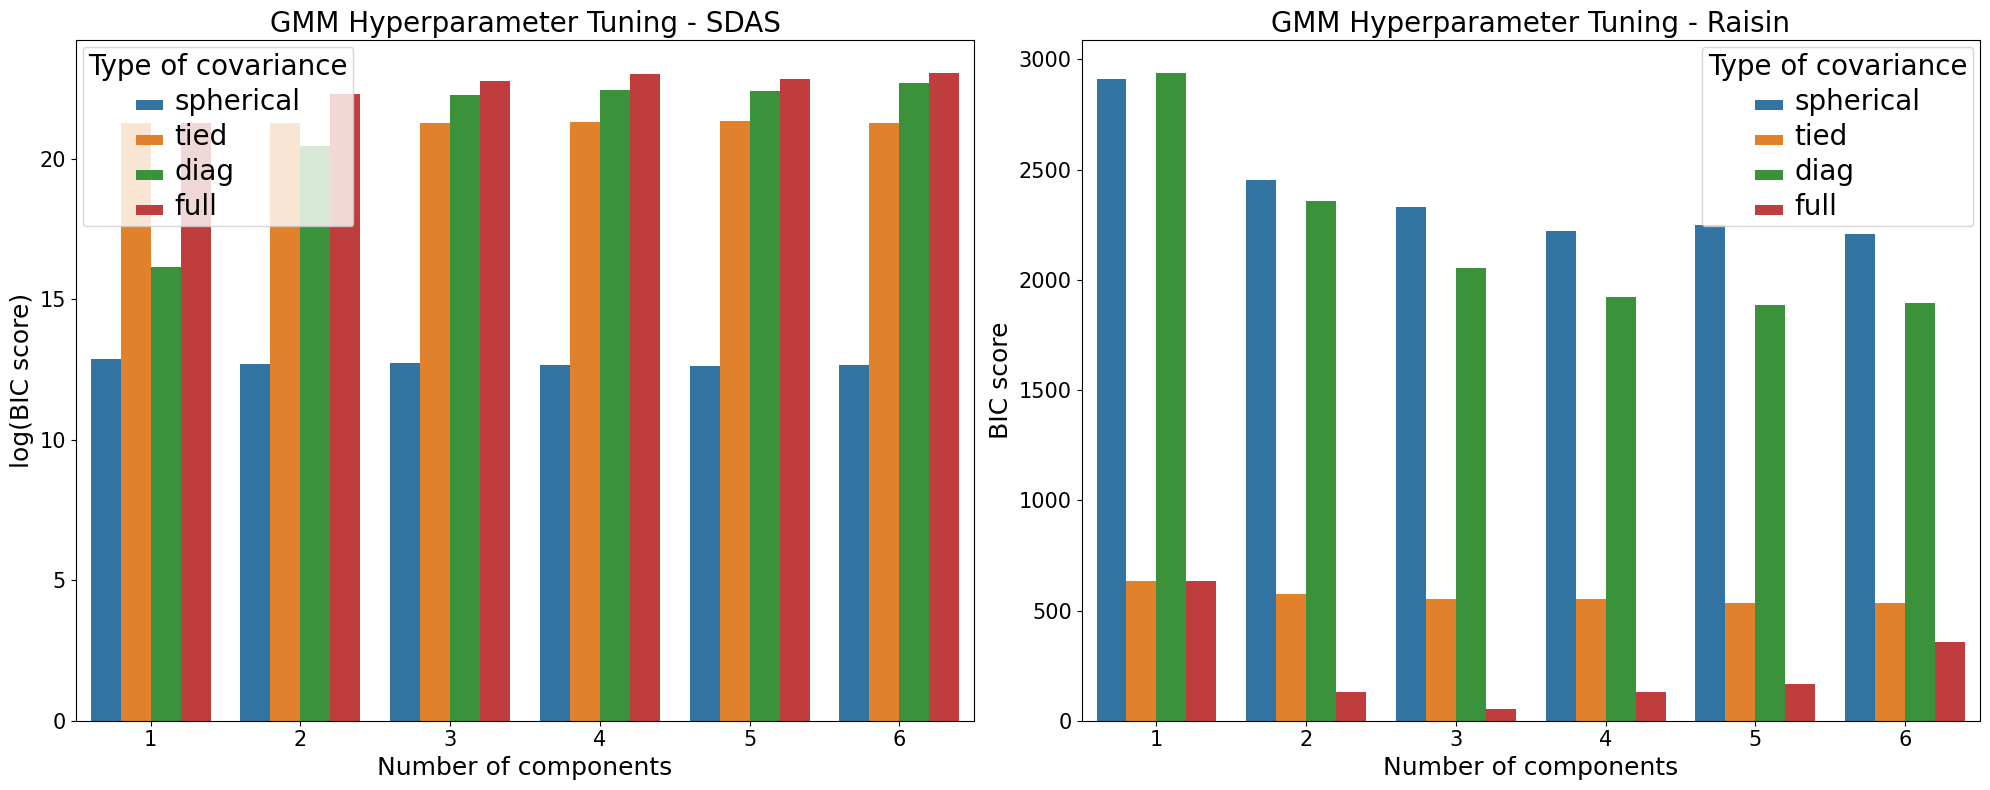

Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
Min BIC score for SDAS: 306992.66473296314
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
Min BIC score for Raisin: 54.834866983853


In [72]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator['classifier'].bic(estimator['preprocessor'].transform(X))  # Make it negative since GridSearchCV expects a score to maximize

from sklearn.model_selection import GridSearchCV
import pandas as pd

import matplotlib.pyplot as plt
import importlib

# Reload the helpers module to get the latest changes
importlib.reload(helpers)
generate_seed()
# Define the parameter grid for GridSearchCV
param_grid = {
    "classifier__n_components": range(1, 7),
    "classifier__covariance_type": ["spherical", "tied", "diag", "full"],
}

# Function to perform GridSearchCV and plot the results
def grid_search_gmm(X_train, category_columns, dataset_name):
    model = pipelines.GMM_pipeline(X_train, list_of_categories=category_columns)
    grid_search = GridSearchCV(
        model, param_grid=param_grid, scoring=gmm_bic_score
    )
    grid_search.fit(X_train)
    
    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_classifier__n_components", "param_classifier__covariance_type", "mean_test_score"]
    ]
    df["mean_test_score"] = -df["mean_test_score"]
    df = df.rename(
        columns={
            "param_classifier__n_components": "Number of components",
            "param_classifier__covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    
    min_bic_score = df["BIC score"].min()
    best_params = grid_search.best_params_
    
    sns.catplot(
        data=df,
        kind="bar",
        x="Number of components",
        y="BIC score",
        hue="Type of covariance",
    ).set(title=f'GMM Hyperparameter Tuning - {dataset_name}')
    
    return min_bic_score, best_params, df

# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = grid_search_gmm(X_train_sdas, CATEGORY_COLUMNS_UCML, "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = grid_search_gmm(X_train_raisin, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_raisin["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(plt)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# source  https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture 


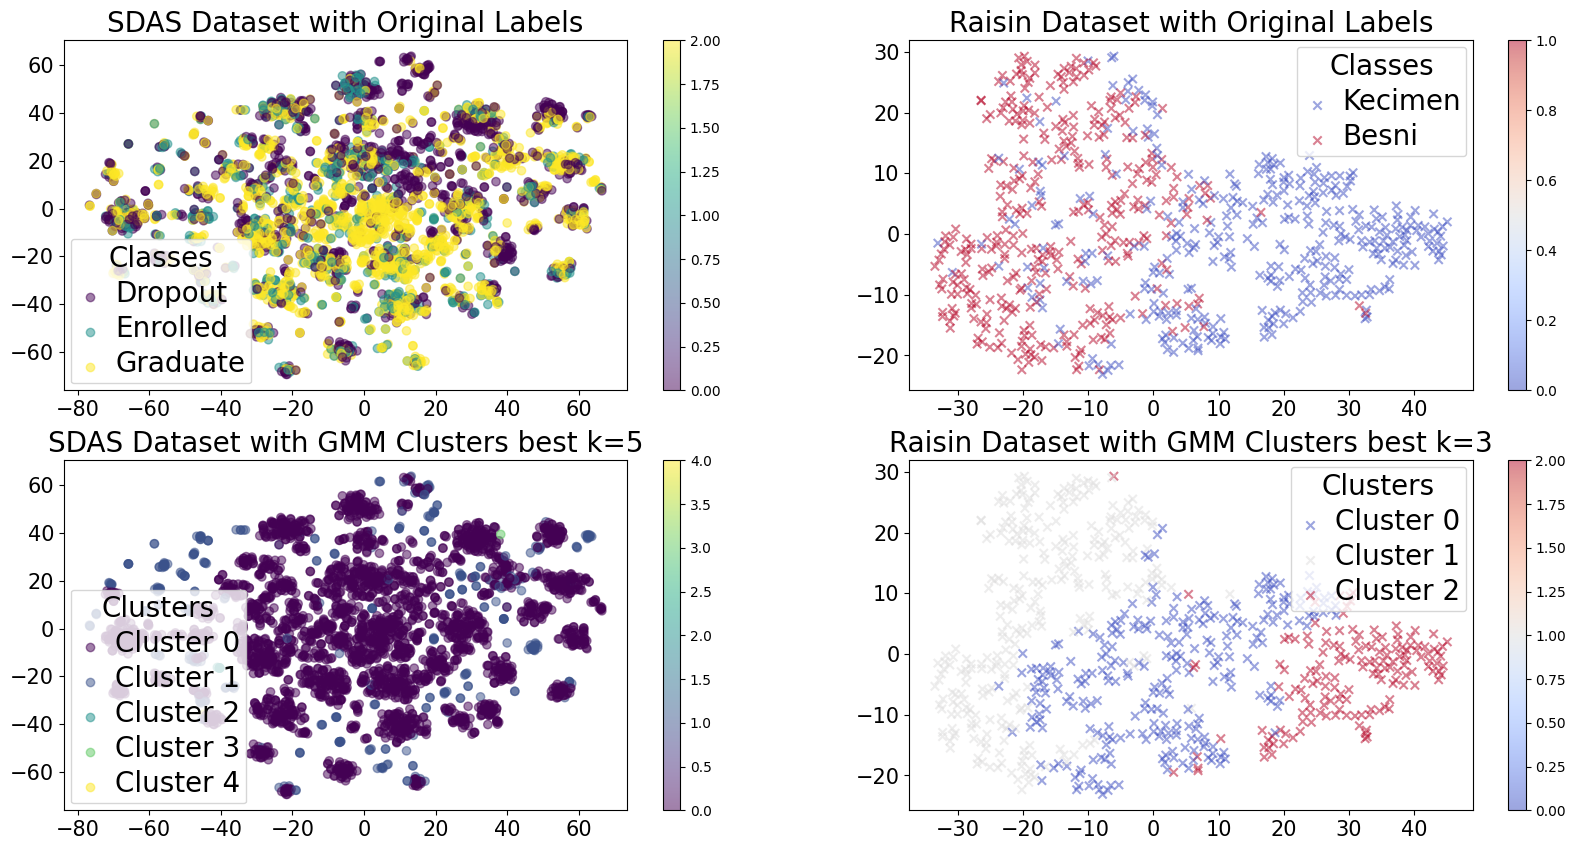

In [75]:
import importlib

# Reload the helpers module to get the latest changes
reload_all()
generate_seed()
# Visualize clusters vs original labels using t-SNE
kwargs_sdas_tsne = {'n_components': 2, 'random_state': 10, 'perplexity': 30}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 10}
tsne_sdas = TSNE_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(X_train_raisin, **kwargs_raisin_tsne)

X_train_sdas_tsne = tsne_sdas.fit_transform(X_train_sdas)
X_train_raisin_tsne = tsne_raisin.fit_transform(X_train_raisin)

# Display confusion matrix for the best K
best_k_sdas = best_params_sdas['classifier__n_components']
best_k_raisin = best_params_raisin['classifier__n_components']

# Fit GMM with best K
gmm_kwargs_sdas = {'n_components': best_params_sdas['classifier__n_components'], 'random_state': 42, "covariance_type":best_params_sdas['classifier__covariance_type'] }
gmm_sdas_best = pipelines.GMM_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **gmm_kwargs_sdas)
gmm_sdas_best.fit(X_train_sdas)
cluster_labels_sdas_best = gmm_sdas_best.predict(X_train_sdas)

gmm_kwargs_raisin = {'n_components': best_params_raisin['classifier__n_components'], 'random_state': 42, "covariance_type":best_params_raisin['classifier__covariance_type'] }
gmm_raisin_best = pipelines.GMM_pipeline(X_train_raisin, **gmm_kwargs_raisin)
gmm_raisin_best.fit(X_train_raisin)
cluster_labels_raisin_best = gmm_raisin_best.predict(X_train_raisin)

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

# Create 2 pairs of subplots
plt.figure(figsize=(20, 10))

# First pair of subplots: Original labels
plt.subplot(2, 2, 1)
plt.title("SDAS Dataset with Original Labels")
scatter_sdas = plt.scatter(X_train_sdas_tsne[:, 0], X_train_sdas_tsne[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [label_mapping_sdas[int(i)] for i in np.unique(y_train_encoded_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
helpers.increase_font_size(plt)

plt.subplot(2, 2, 2)
plt.title("Raisin Dataset with Original Labels")
scatter_raisin = plt.scatter(X_train_raisin_tsne[:, 0], X_train_raisin_tsne[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [label_mapping_raisin[int(i)] for i in np.unique(y_train_encode_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")
helpers.increase_font_size(plt)

# Second pair of subplots: GMM clusters
plt.subplot(2, 2, 3)
plt.title(f"SDAS Dataset with GMM Clusters best k={best_params_sdas['classifier__n_components']}")
scatter_sdas_gmm = plt.scatter(X_train_sdas_tsne[:, 0], X_train_sdas_tsne[:, 1], c=cluster_labels_sdas_best, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS GMM clusters
handles_sdas_gmm, _ = scatter_sdas_gmm.legend_elements()
labels_sdas_gmm = [f"Cluster {int(i)}" for i in np.unique(cluster_labels_sdas_best)]
plt.legend(handles_sdas_gmm, labels_sdas_gmm, title="Clusters")
helpers.increase_font_size(plt)

plt.subplot(2, 2, 4)
plt.title(f"Raisin Dataset with GMM Clusters best k={ best_params_raisin['classifier__n_components']}")
scatter_raisin_gmm = plt.scatter(X_train_raisin_tsne[:, 0], X_train_raisin_tsne[:, 1], c=cluster_labels_raisin_best, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin GMM clusters
handles_raisin_gmm, _ = scatter_raisin_gmm.legend_elements()
labels_raisin_gmm = [f"Cluster {int(i)}" for i in np.unique(cluster_labels_raisin_best)]
plt.legend(handles_raisin_gmm, labels_raisin_gmm, title="Clusters")
helpers.increase_font_size(plt)



In [83]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], cluster_labels_sdas_best, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": cluster_labels_sdas_best})

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Dropout")



# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": cluster_labels_sdas_best})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Dropout")

# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.307644  0.885068
1  Enrolled   0.000000  0.000000
2  Graduate   0.430556  0.086544


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


True Labels,Dropout,Enrolled,Graduate
Cluster Labels,,,
0,978.0,565.0,1636.0
1,125.0,77.0,150.0
2,2.0,0.0,4.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [85]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], cluster_labels_raisin_best, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": cluster_labels_raisin_best})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x== 0 or x==2 else "Kecimen")



# Map cluster labels to the original labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": cluster_labels_raisin_best})
cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x else "Kecimen")

# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.446953  0.543956
1  Kecimen   0.400722  0.311798


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels,Besni,Kecimen
Cluster Labels,,
0,166,111
1,45,243
2,153,2


## Fit and Score Times

In [21]:
import pandas as pd
reload_notebook_cell()
# Best parameters for GMM
gmm_kwargs_sdas = {'covariance_type': 'spherical', 'n_components': 5, 'random_state': 42}
gmm_kwargs_raisin = {'covariance_type': 'full', 'n_components': 3, 'random_state': 42}

# Best parameters for KMeans
kmean_kwargs_sdas = {'n_clusters': 2, 'random_state': 42}
kmean_kwargs_raisin = {'n_clusters': 2, 'random_state': 42}

# Create the pipelines
kmeans_sdas = pipelines.KMeans_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **kmean_kwargs_sdas)
kmeans_raisin = pipelines.KMeans_pipeline(X_train_raisin, **kmean_kwargs_raisin)

gmm_sdas_best = pipelines.GMM_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, **gmm_kwargs_sdas)
gmm_raisin_best = pipelines.GMM_pipeline(X_train_raisin, **gmm_kwargs_raisin)


In [22]:
# Measure fit and score times for each pipeline
fit_times = {
    'KMeans SDAS': pipeline_helpers.measure_fit_time(kmeans_sdas, X_train_sdas),
    'KMeans Raisin': pipeline_helpers.measure_fit_time(kmeans_raisin, X_train_raisin),
    'GMM SDAS': pipeline_helpers.measure_fit_time(gmm_sdas_best, X_train_sdas),
    'GMM Raisin': pipeline_helpers.measure_fit_time(gmm_raisin_best, X_train_raisin),
}

score_times = {
    'KMeans SDAS': pipeline_helpers.measure_score_time(kmeans_sdas, X_train_sdas),
    'KMeans Raisin': pipeline_helpers.measure_score_time(kmeans_raisin, X_train_raisin),
    'GMM SDAS': pipeline_helpers.measure_score_time(gmm_sdas_best, X_train_sdas),
    'GMM Raisin': pipeline_helpers.measure_score_time(gmm_raisin_best, X_train_raisin),
}

# Create a DataFrame from the dictionaries
df_times = pd.DataFrame({
    'Pipeline': list(fit_times.keys()),
    'Fit Time': list(fit_times.values()),
    'Score Time': list(score_times.values())
})

# Display the DataFrame
print(df_times)

        Pipeline  Fit Time  Score Time
0    KMeans SDAS  0.052677    0.016515
1  KMeans Raisin  0.015267    0.006442
2       GMM SDAS  0.200071    0.013094
3     GMM Raisin  0.136657    0.000197


In [58]:
X_standardized = np.array([[
    1,2,3
],                           
[2,3,4],
[3,4,5],
[4,5,1]]
)

X_standardized_reconstruct = X_standardized*1

# error = np.mean(np.sum(np.square(X_standardized - X_reconstructed), axis=1))
np.sum(np.abs(1-np.sqrt(np.sum((X_standardized - X_standardized_reconstruct)**2 , axis=1))/ np.sqrt(np.mean(X_standardized**2,axis=1))))/X_standardized.shape[0]

1.0

In [50]:
np.mean(X_standardized**2,axis=1)

array([ 4.66666667,  9.66666667, 16.66666667, 14.        ])